# Report
Bart van Lieshout   S1805967 <br>
Jesper Molenkamp    S1775138 <br>
Pepijn Rakers       S1881884

## Packages
Download and import packages required to run the code in this notebook.

In [1]:
# modules
!pip install oddt | grep -v 'already satisfied'
!pip install vina | grep -v 'already satisfied'
import sys, os, shutil
import nglview
from Bio.PDB import PDBParser, PDBIO, Select,  PDBList, MMCIFParser, StructureAlignment
import Bio.Align
from Bio import pairwise2
from Bio.Seq import Seq 
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment
from pathlib import Path
import rdkit
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.Chem import AllChem, Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import MolsToGridImage
import numpy as np
import pandas as pd
import requests
import math
from math import isnan, isinf

from pathlib import Path
from warnings import filterwarnings
import time

from sklearn import svm, metrics, clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import auc, accuracy_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import py3Dmol
import glob
from vina import Vina
import MDAnalysis as mda
from MDAnalysis.coordinates import PDB
sys.path.insert(1, '/project/jhllei001/JHL_data/Jupyter_Dock/utilities')
import pubchempy as pcp
import time
from urllib.parse import quote

from IPython.display import Markdown, Image
import requests




import warnings
warnings.filterwarnings("ignore")
%config Completer.use_jedi = False

# local scripts
from scripts import viewer
from scripts import bio_align
from utils import seed_everything

  Using cached oddt-0.7-py2.py3-none-any.whl
  Using cached numpydoc-1.5.0-py3-none-any.whl (52 kB)
  Using cached sphinx-5.3.0-py3-none-any.whl (3.2 MB)
  Using cached sphinxcontrib_serializinghtml-1.1.5-py2.py3-none-any.whl (94 kB)
  Using cached sphinxcontrib_htmlhelp-2.0.0-py2.py3-none-any.whl (100 kB)
  Using cached sphinxcontrib_applehelp-1.0.2-py2.py3-none-any.whl (121 kB)
  Using cached snowballstemmer-2.2.0-py2.py3-none-any.whl (93 kB)
  Using cached docutils-0.19-py3-none-any.whl (570 kB)
  Using cached sphinxcontrib_qthelp-1.0.3-py2.py3-none-any.whl (90 kB)
  Using cached imagesize-1.4.1-py2.py3-none-any.whl (8.8 kB)
  Using cached sphinxcontrib_jsmath-1.0.1-py2.py3-none-any.whl (5.1 kB)
  Using cached alabaster-0.7.12-py2.py3-none-any.whl (14 kB)
  Using cached sphinxcontrib_devhelp-1.0.2-py2.py3-none-any.whl (84 kB)
  Using cached vina-1.2.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (7.1 MB)


/opt/conda/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


## Functions

In [2]:
def smiles_to_fp(smiles, method="maccs", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.

    """

    # convert smiles to RDKit mol object
    try:
        mol = Chem.MolFromSmiles(smiles)
        
    except:
        return('NaN')

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        return np.array(GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits))
    if method == "morgan3":
        return np.array(GetMorganFingerprintAsBitVect(mol, 3, nBits=n_bits))
    else:
        # NBVAL_CHECK_OUTPUT
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    
    
    
def plot_roc_curves_for_models(models, test_x, test_y, save_png=True):
    """
    Helper function to plot customized roc curve.

    Parameters
    ----------
    models: dict
        Dictionary of pretrained machine learning models.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    save_png: bool
        Save image to disk (default = False)

    Returns
    -------
    fig:
        Figure.
    """

    fig, ax = plt.subplots()

    # Below for loop iterates through your models list
    for model in models:
        # Select the model
        ml_model = model["model"]
        # Prediction probability on test set
        test_prob = ml_model.predict_proba(test_x)[:, 1]
        # Prediction class on test set
        test_pred = ml_model.predict(test_x)
        # Compute False postive rate and True positive rate
        fpr, tpr, thresholds = metrics.roc_curve(test_y, test_prob)
        # Calculate Area under the curve to display on the plot
        auc = roc_auc_score(test_y, test_prob)
        # Plot the computed values
        ax.plot(fpr, tpr, label=(f"{model['label']} AUC area = {auc:.2f}"))

    # Custom settings for the plot
    ax.plot([0, 1], [0, 1], "r--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver Operating Characteristic")
    ax.legend(loc="lower right")
    # Save plot
    if save_png:
        fig.savefig(f"results/roc_auc", dpi=300, bbox_inches="tight", transparent=True)
    return fig



def model_performance(ml_model, test_x, test_y, verbose=True):
    """
    Helper function to calculate model performance

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    verbose: bool
        Print performance measure (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.
    """

    # Prediction probability on test set
    test_prob = ml_model.predict_proba(test_x)[:, 1]

    # Prediction class on test set
    test_pred = ml_model.predict(test_x)

    # Performance of model on test set
    accuracy = accuracy_score(test_y, test_pred)
    sens = recall_score(test_y, test_pred)
    spec = recall_score(test_y, test_pred, pos_label=0)
    auc = roc_auc_score(test_y, test_prob)

    if verbose:
        # Print performance results
        # NBVAL_CHECK_OUTPUT        print(f"Accuracy: {accuracy:.2}")
        print(f"Sensitivity: {sens:.2f}")
        print(f"Specificity: {spec:.2f}")
        print(f"AUC: {auc:.2f}")

    return accuracy, sens, spec, auc


def model_training_and_validation(ml_model, name, splits, verbose=True):
    """
    Fit a machine learning model on a random train-test split of the data
    and return the performance measures.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    name: str
        Name of machine learning algorithm: RF, SVM, ANN
    splits: list
        List of desciptor and label data: train_x, test_x, train_y, test_y.
    verbose: bool
        Print performance info (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.

    """
    train_x, test_x, train_y, test_y = splits

    # Fit the model
    ml_model.fit(train_x, train_y)

    # Calculate model performance results
    accuracy, sens, spec, auc = model_performance(ml_model, test_x, test_y, verbose)

    return accuracy, sens, spec, auc

def crossvalidation(ml_model, df, n_folds=5, verbose=False):
    """
    Machine learning model training and validation in a cross-validation loop.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    df: pd.DataFrame
        Data set with SMILES and their associated activity labels.
    n_folds: int, optional
        Number of folds for cross-validation.
    verbose: bool, optional
        Performance measures are printed.

    Returns
    -------
    None

    """
    t0 = time.time()
    # Shuffle the indices for the k-fold cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)

    # Results for each of the cross-validation folds
    acc_per_fold = []
    sens_per_fold = []
    spec_per_fold = []
    auc_per_fold = []

    # Loop over the folds
    for train_index, test_index in kf.split(df):
        # clone model -- we want a fresh copy per fold!
        fold_model = clone(ml_model)
        # Training

        # Convert the fingerprint and the label to a list
        train_x = df.iloc[train_index].fp.tolist()
        train_y = df.iloc[train_index].active.tolist()

        # Fit the model
        fold_model.fit(train_x, train_y)

        # Testing

        # Convert the fingerprint and the label to a list
        test_x = df.iloc[test_index].fp.tolist()
        test_y = df.iloc[test_index].active.tolist()

        # Performance for each fold
        accuracy, sens, spec, auc = model_performance(fold_model, test_x, test_y, verbose)

        # Save results
        acc_per_fold.append(accuracy)
        sens_per_fold.append(sens)
        spec_per_fold.append(spec)
        auc_per_fold.append(auc)

    # Print statistics of results
    print(
        f"Mean accuracy: {np.mean(acc_per_fold):.2f} \t"
        f"and std : {np.std(acc_per_fold):.2f} \n"
        f"Mean sensitivity: {np.mean(sens_per_fold):.2f} \t"
        f"and std : {np.std(sens_per_fold):.2f} \n"
        f"Mean specificity: {np.mean(spec_per_fold):.2f} \t"
        f"and std : {np.std(spec_per_fold):.2f} \n"
        f"Mean AUC: {np.mean(auc_per_fold):.2f} \t"
        f"and std : {np.std(auc_per_fold):.2f} \n"
        f"Time taken : {time.time() - t0:.2f}s\n"
    )

    return acc_per_fold, sens_per_fold, spec_per_fold, auc_per_fold




def crossvalidation_reg(ml_model, df, n_folds=5, verbose=False):
    """
    Machine learning model training and validation in a cross-validation loop.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    df: pd.DataFrame
        Data set with SMILES and their associated activity labels.
    n_folds: int, optional
        Number of folds for cross-validation.
    verbose: bool, optional
        Performance measures are printed.

    Returns
    -------
    None

    """
    t0 = time.time()
    # Shuffle the indices for the k-fold cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)

    # Results for each of the cross-validation folds
    MAE_per_fold = []
    RMSE_per_fold = []

    # Loop over the folds
    for train_index, test_index in kf.split(df):
        # clone model -- we want a fresh copy per fold!
        fold_model = clone(ml_model)
        # Training

        # Convert the fingerprint and the label to a list
        train_x = df.iloc[train_index].fp.tolist()
        train_y = df.iloc[train_index].pChEMBL_value.tolist()

        # Fit the model
        fold_model.fit(train_x, train_y)

        # Testing

        # Convert the fingerprint and the label to a list
        test_x = df.iloc[test_index].fp.tolist()
        test_y = df.iloc[test_index].pChEMBL_value.tolist()
        
        test_results = fold_model.predict(test_x)
        # Prediction probability on test set
        from sklearn import metrics

        MAE_per_fold.append(metrics.mean_absolute_error(test_y, test_results))
        #print('Mean Squared Error (MSE):', metrics.mean_squared_error(test_y, test_results))
        RMSE_per_fold.append(np.sqrt(metrics.mean_squared_error(test_y, test_results)))
        #mape = np.mean(np.abs((gt - pred) / np.abs(gt)))
        #print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
        #print('Accuracy:', round(100*(1 - mape), 2))
    return(MAE_per_fold,RMSE_per_fold,fold_model)

#pubchem query functions

def query_pubchem_for_similar_compounds(smiles, threshold=80, n_records=10, logp=5, MW=1000):
    """
    Query PubChem for similar compounds and return the job key.

    Parameters
    ----------
    smiles : str
        The canonical SMILES string for the given compound.
    threshold : int
        The threshold of similarity, default 75%. In PubChem, the default threshold is 90%.
    n_records : int
        The maximum number of feedback records.

    Returns
    -------
    str
        The job key from the PubChem web service.
    """
    escaped_smiles = quote(smiles).replace("/", ".")
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/similarity/smiles/{escaped_smiles}/JSON?Threshold={threshold}&MaxRecords={n_records}&fullsearch=true&mw_lte={MW}&xlogp_lte={logp}"
    r = requests.get(url)
    r.raise_for_status()
    key = r.json()["Waiting"]["ListKey"]
    return key


def check_and_download(key, attempts=30):
    """
    Check job status and download PubChem CIDs when the job finished

    Parameters
    ----------
    key : str
        The job key of the PubChem service.
    attempts : int
        The time waiting for the feedback from the PubChem service.

    Returns
    -------
    list
        The PubChem CIDs of similar compounds.
    """
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/listkey/{key}/cids/JSON"
    print(f"Querying for job {key} at URL {url}...", end="")
    while attempts:
        r = requests.get(url)
        r.raise_for_status()
        response = r.json()
        if "IdentifierList" in response:
            cids = response["IdentifierList"]["CID"]
            break
        attempts -= 1
        print(".", end="")
        time.sleep(10)
    else:
        raise ValueError(f"Could not find matches for job key: {key}")
    return cids

def smiles_from_pubchem_cids(cids):
    """
    Get the canonical SMILES string from the PubChem CIDs.

    Parameters
    ----------
    cids : list
        A list of PubChem CIDs.

    Returns
    -------
    list
        The canonical SMILES strings of the PubChem CIDs.
    """
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{','.join(map(str, cids))}/property/CanonicalSMILES/JSON"
    r = requests.get(url)
    r.raise_for_status()
    return [item["CanonicalSMILES"] for item in r.json()["PropertyTable"]["Properties"]]


def PDBQTAtomLines(mol, donors, acceptors):
    """Create a list with PDBQT atom lines for each atom in molecule. Donors
    and acceptors are given as a list of atom indices.
    """

    atom_lines = [line.replace('HETATM', 'ATOM  ')
                  for line in Chem.MolToPDBBlock(mol).split('\n')
                  if line.startswith('HETATM') or line.startswith('ATOM')]

    pdbqt_lines = []
    for idx, atom in enumerate(mol.GetAtoms()):
        pdbqt_line = atom_lines[idx][:56]

        pdbqt_line += '0.00  0.00    '  # append empty vdW and ele
        # Get charge
        charge = 0.
        fields = ['_MMFF94Charge', '_GasteigerCharge', '_TriposPartialCharge']
        for f in fields:
            if atom.HasProp(f):
                charge = atom.GetDoubleProp(f)
                break
        # FIXME: this should not happen, blame RDKit
        if isnan(charge) or isinf(charge):
            charge = 0.
        pdbqt_line += ('%.3f' % charge).rjust(6)

        # Get atom type
        pdbqt_line += ' '
        atomicnum = atom.GetAtomicNum()
        if atomicnum == 6 and atom.GetIsAromatic():
            pdbqt_line += 'A'
        elif atomicnum == 7 and idx in acceptors:
            pdbqt_line += 'NA'
        elif atomicnum == 8 and idx in acceptors:
            pdbqt_line += 'OA'
        elif atomicnum == 1 and atom.GetNeighbors()[0].GetIdx() in donors:
            pdbqt_line += 'HD'
        else:
            pdbqt_line += atom.GetSymbol()
        pdbqt_lines.append(pdbqt_line)
    return pdbqt_lines

def MolToPDBQTBlock(mol, flexible=True, addHs=False, computeCharges=False):
    """Write RDKit Molecule to a PDBQT block

    Parameters
    ----------
        mol: rdkit.Chem.rdchem.Mol
            Molecule with a protein ligand complex
        flexible: bool (default=True)
            Should the molecule encode torsions. Ligands should be flexible,
            proteins in turn can be rigid.
        addHs: bool (default=False)
            The PDBQT format requires at least polar Hs on donors. By default Hs
            are added.
        computeCharges: bool (default=False)
            Should the partial charges be automatically computed. If the Hs are
            added the charges must and will be recomputed. If there are no
            partial charge information, they are set to 0.0.

    Returns
    -------
        block: str
            String wit PDBQT encoded molecule
    """
    # make a copy of molecule
    mol = Chem.Mol(mol)

    # if flexible molecule contains multiple fragments write them separately
    if flexible and len(Chem.GetMolFrags(mol)) > 1:
        return ''.join(MolToPDBQTBlock(frag, flexible=flexible, addHs=addHs,
                                       computeCharges=computeCharges)
                       for frag in Chem.GetMolFrags(mol, asMols=True))

    # Identify donors and acceptors for atom typing
    # Acceptors
    patt = Chem.MolFromSmarts('[$([O;H1;v2]),'
                              '$([O;H0;v2;!$(O=N-*),'
                              '$([O;-;!$(*-N=O)]),'
                              '$([o;+0])]),'
                              '$([n;+0;!X3;!$([n;H1](cc)cc),'
                              '$([$([N;H0]#[C&v4])]),'
                              '$([N&v3;H0;$(Nc)])]),'
                              '$([F;$(F-[#6]);!$(FC[F,Cl,Br,I])])]')
    acceptors = list(map(lambda x: x[0],
                         mol.GetSubstructMatches(patt, maxMatches=mol.GetNumAtoms())))
    # Donors
    patt = Chem.MolFromSmarts('[$([N&!H0&v3,N&!H0&+1&v4,n&H1&+0,$([$([Nv3](-C)(-C)-C)]),'
                              '$([$(n[n;H1]),'
                              '$(nc[n;H1])])]),'
                              # Guanidine can be tautormeic - e.g. Arginine
                              '$([NX3,NX2]([!O,!S])!@C(!@[NX3,NX2]([!O,!S]))!@[NX3,NX2]([!O,!S])),'
                              '$([O,S;H1;+0])]')
    donors = list(map(lambda x: x[0],
                      mol.GetSubstructMatches(patt, maxMatches=mol.GetNumAtoms())))
    if addHs:
        mol = Chem.AddHs(mol, addCoords=True, onlyOnAtoms=donors, )
    if addHs or computeCharges:
        AllChem.ComputeGasteigerCharges(mol)

    atom_lines = PDBQTAtomLines(mol, donors, acceptors)
    assert len(atom_lines) == mol.GetNumAtoms()

    pdbqt_lines = []

    # vina scores
    if (mol.HasProp('vina_affinity') and mol.HasProp('vina_rmsd_lb') and
            mol.HasProp('vina_rmsd_lb')):
        pdbqt_lines.append('REMARK VINA RESULT:  ' +
                           ('%.1f' % float(mol.GetProp('vina_affinity'))).rjust(8) +
                           ('%.3f' % float(mol.GetProp('vina_rmsd_lb'))).rjust(11) +
                           ('%.3f' % float(mol.GetProp('vina_rmsd_ub'))).rjust(11))

    pdbqt_lines.append('REMARK  Name = ' +
                       (mol.GetProp('_Name') if mol.HasProp('_Name') else ''))
    if flexible:
        # Find rotatable bonds
        rot_bond = Chem.MolFromSmarts('[!$(*#*)&!D1&!$(C(F)(F)F)&'
                                      '!$(C(Cl)(Cl)Cl)&'
                                      '!$(C(Br)(Br)Br)&'
                                      '!$(C([CH3])([CH3])[CH3])&'
                                      '!$([CD3](=[N,O,S])-!@[#7,O,S!D1])&'
                                      '!$([#7,O,S!D1]-!@[CD3]=[N,O,S])&'
                                      '!$([CD3](=[N+])-!@[#7!D1])&'
                                      '!$([#7!D1]-!@[CD3]=[N+])]-!@[!$(*#*)&'
                                      '!D1&!$(C(F)(F)F)&'
                                      '!$(C(Cl)(Cl)Cl)&'
                                      '!$(C(Br)(Br)Br)&'
                                      '!$(C([CH3])([CH3])[CH3])]')
        bond_atoms = list(mol.GetSubstructMatches(rot_bond))
        num_torsions = len(bond_atoms)

        # Active torsions header
        pdbqt_lines.append('REMARK  %i active torsions:' % num_torsions)
        pdbqt_lines.append('REMARK  status: (\'A\' for Active; \'I\' for Inactive)')
        for i, (a1, a2) in enumerate(bond_atoms):
            pdbqt_lines.append('REMARK%5.0i  A    between atoms: _%i  and  _%i'
                               % (i + 1, a1 + 1, a2 + 1))

        # Fragment molecule on bonds to ge rigid fragments
        bond_ids = [mol.GetBondBetweenAtoms(a1, a2).GetIdx()
                    for a1, a2 in bond_atoms]
        if bond_ids:
            mol_rigid_frags = Chem.FragmentOnBonds(mol, bond_ids, addDummies=False)
        else:
            mol_rigid_frags = mol
        frags = list(Chem.GetMolFrags(mol_rigid_frags))

        def weigh_frags(frag):
            """sort by the fragment size and the number of bonds (secondary)"""
            num_bonds = 0
            # bond_weight = 0
            for a1, a2 in bond_atoms:
                if a1 in frag or a2 in frag:
                    num_bonds += 1
                    # for frag2 in frags:
                    #     if a1 in frag2 or a2 in frag2:
                    #         bond_weight += len(frag2)

            # changed signs are fixing mixed sorting type (ascending/descending)
            return -len(frag), -num_bonds,  # bond_weight
        frags = sorted(frags, key=weigh_frags)

        # Start writting the lines with ROOT
        pdbqt_lines.append('ROOT')
        frag = frags.pop(0)
        for idx in frag:
            pdbqt_lines.append(atom_lines[idx])
        pdbqt_lines.append('ENDROOT')

        # Now build the tree of torsions usign DFS algorithm. Keep track of last
        # route with following variables to move down the tree and close branches
        branch_queue = []
        current_root = frag
        old_roots = [frag]

        visited_frags = []
        visited_bonds = []
        while len(frags) > len(visited_frags):
            end_branch = True
            for frag_num, frag in enumerate(frags):
                for bond_num, (a1, a2) in enumerate(bond_atoms):
                    if (frag_num not in visited_frags and
                        bond_num not in visited_bonds and
                        (a1 in current_root and a2 in frag or
                         a2 in current_root and a1 in frag)):
                        # direction of bonds is important
                        if a1 in current_root:
                            bond_dir = '%i %i' % (a1 + 1, a2 + 1)
                        else:
                            bond_dir = '%i %i' % (a2 + 1, a1 + 1)
                        pdbqt_lines.append('BRANCH %s' % bond_dir)
                        for idx in frag:
                            pdbqt_lines.append(atom_lines[idx])
                        branch_queue.append('ENDBRANCH %s' % bond_dir)

                        # Overwrite current root and stash previous one in queue
                        old_roots.append(current_root)
                        current_root = frag

                        # remove used elements from stack
                        visited_frags.append(frag_num)
                        visited_bonds.append(bond_num)

                        # mark that we dont want to end branch yet
                        end_branch = False
                        break
                    else:
                        continue
                    break  # break the outer loop as well

            if end_branch:
                pdbqt_lines.append(branch_queue.pop())
                if old_roots:
                    current_root = old_roots.pop()
        # close opened branches if any is open
        while len(branch_queue):
            pdbqt_lines.append(branch_queue.pop())
        pdbqt_lines.append('TORSDOF %i' % num_torsions)
    else:
        pdbqt_lines.extend(atom_lines)

    return '\n'.join(pdbqt_lines)

def MolFromPDBQTBlock(filename, sanitize=True, removeHs=True):
    """Read PDBQT block to a RDKit Molecule
    Parameters
    ----------
        block: string
            Residue name which explicitly pint to a ligand(s).
        sanitize: bool (default=True)
            Should the sanitization be performed
        removeHs: bool (default=True)
            Should hydrogens be removed when reading molecule.
    Returns
    -------
        mol: rdkit.Chem.rdchem.Mol
            Molecule read from PDBQT
    """
    pdb_lines = []
    name = ''
    data = {}
    with open(filename) as file:
        lines = file.readlines()
        block = [line.rstrip() for line in lines]
        
    for line in block: #.split('\n'):
        # Get all know data from REMARK section
        if line[:12] == 'REMARK  Name':
            name = line[15:].strip()
        elif line[:18] == 'REMARK VINA RESULT':
            tmp = line[19:].split()
            data['vina_affinity'] = tmp[0]
            data['vina_rmsd_lb'] = tmp[1]
            data['vina_rmsd_ub'] = tmp[2]

        # no more data to collect
        if line[:4] != 'ATOM':
            continue

        pdb_line = line[:56]
        pdb_line += '1.00  0.00           '

        # Do proper atom type lookup
        atom_type = line[71:].split()[1]
        if atom_type == 'A':
            atom_type = 'C'
        elif atom_type[:1] == 'O':
            atom_type = 'O'
        elif atom_type[:1] == 'H':
            atom_type = 'H'
            if removeHs:
                continue
        elif atom_type == 'NA':
            atom_type = 'N'

        pdb_lines.append(pdb_line + atom_type)
    mol = Chem.MolFromPDBBlock('\n'.join(pdb_lines), sanitize=False)
    if sanitize:
        Chem.SanitizeMol(mol)
    else:
        Chem.GetSSSR(mol)
    # reorder atoms using serial
    new_order = sorted(range(mol.GetNumAtoms()),
                       key=lambda i: (mol.GetAtomWithIdx(i)
                                      .GetPDBResidueInfo()
                                      .GetSerialNumber()))
    mol = Chem.RenumberAtoms(mol, new_order)

    # properties must be set on final copy of Mol, RenumberAtoms purges data
    mol.SetProp('_Name', name)
    for k, v in data.items():
        mol.SetProp(str(k), str(v))

    return mol



def Rg(filename):
    '''
    Calculates the Radius of Gyration (Rg) of a protein given its .pdb 
    structure file. Returns the Rg integer value in Angstrom.
    '''
    coord = list()
    mass = list()
    Structure = open(filename, 'r')
    for line in Structure:
        try:
            line = line.split()
            x = float(line[6])
            y = float(line[7])
            z = float(line[8])
            coord.append([x, y, z])
            if line[-1] == 'C':
                mass.append(12.0107)
            elif line[-1] == 'O':
                mass.append(15.9994)
            elif line[-1] == 'N':
                mass.append(14.0067)
            elif line[-1] == 'S':
                mass.append(32.065)
        except:
            pass
    xm = [(m*i, m*j, m*k) for (i, j, k), m in zip(coord, mass)]
    tmass = sum(mass)
    rr = sum(mi*i + mj*j + mk*k for (i, j, k), (mi, mj, mk) in zip(coord, xm))
    mm = sum((sum(i) / tmass)**2 for i in zip(*xm))
    rg = math.sqrt(rr / tmass-mm)
    return(round(rg, 3))

def COG(pdbfile, include='ATOM,HETATM'):
    """
    Calculates center of geometry of a protein and/or ligand structure.
    Returns:
        center (list): List of float coordinates [x,y,z] that represent the
        center of geometry (precision 3).
    """

    center = [None, None, None]
    include = tuple(include.split(','))

    with open(pdbfile) as pdb:

        # extract coordinates [ [x1,y1,z1], [x2,y2,z2], ... ]
        coordinates = []
        for line in pdb:
            if line.startswith(include):
                coordinates.append([float(line[30:38]),    # x_coord
                                    float(line[38:46]),    # y_coord
                                    float(line[46:54])     # z_coord
                                   ])

        # calculate center of geometry
        center = [sum([coordinates[i][j]/(len(coordinates))
              for i in range(len(coordinates))]) for j in range(3)]
        center = [round(center[i], 3) for i in range(3)]
    return center




Set the working directory to the Report_data folder. <br>
Changes permission of the lepro file.


In [3]:
HOMEDIR = str(Path.home())+"/ACMDD_Tyk2_2022" #Here we set the directory that we are working in
HOMEDIR
os.chdir(HOMEDIR)
# We need to check whether the directory is there
try:
    os.mkdir('Report_data')
except:
    print("Directory already exists")
os.chdir('Report_data')

SEED = 1
seed_everything(SEED)
os.getcwd()



!chmod 755 ../bin/lepro # needed to get permission to use the LePro too

if os.access('../bin/lepro', os.R_OK) == True:        # making sure we have access to the LePro tool
    print("You have permission to the LePro tool")
elif os.access('../bin/lepro', os.R_OK) == False:
    print("You have no permission to the LePro tool")

Directory already exists
You have permission to the LePro tool



# Bioinformatics

Below, a dataframe is made that consists of information about the target, the same target in a different species, and the most closely related protein in the same species that is not an isoform

## Analyzing your target

Interleukins are a type of cytokine that are capable of modulating the immune response when foreign substances are found in the body. However the immune response can sometimes be triggered by the body itself resulting in autoimmune diseases such as psoriasis. Targeting the Tyk2 receptor can reduce the effect some of the interleukins, reducing the immune response and alleviating symptoms of these diseases. It was only recently (september 2022) that a Tyk2 specific inhibitor was approved for treatment of medium to severe psoriasis, however drugs targeting the overarching JAK family proteins like Peficitinib have been around for a few years. The Tyk2 protein forms dimers with other JAK family proteins and can be found embedded in the cell membrane. 


In [4]:
#Dataframe of the target, the target in a different species, and the protein closest to the target that is not an isoform.

proteins = pd.DataFrame({"Protein name":["Non-receptor tyrosine-protein kinase","Tyrosine-protein kinase","Tyrosine-protein kinase"],
              "Protein family":["JAK","JAK","JAK"],
              "Gene":["TYK2","TYK2","JAK1"],
              "Species":["Homo sapiens (Human)","Pan troglodytes (Chimpanzee)","Homo sapiens (Human)"],
              "Accession number":["P29597","K7AU67","P23458"],
              "Amino acid length":[1187,1187,1154],
              "Identity (%)":[100, 99.2, 46.9],
              "Mass (Da)":[133650,133769,133277],
              "Protein existence":["Evidence at protein level","Evidence at transcript level","Evidence at protein level"],
              "Status":["UniProtKB reviewed (Swiss-Prot)","UniProtKB unreviewed (TrEMBL)","UniProtKB reviewed (Swiss-Prot)"]})

display(proteins)

,Protein name,Protein family,Gene,Species,Accession number,Amino acid length,Identity (%),Mass (Da),Protein existence,Status
0,Non-receptor tyrosine-protein kinase,JAK,TYK2,Homo sapiens (Human),P29597,1187,100.0,133650,Evidence at protein level,UniProtKB reviewed (Swiss-Prot)
1,Tyrosine-protein kinase,JAK,TYK2,Pan troglodytes (Chimpanzee),K7AU67,1187,99.2,133769,Evidence at transcript level,UniProtKB unreviewed (TrEMBL)
2,Tyrosine-protein kinase,JAK,JAK1,Homo sapiens (Human),P23458,1154,46.9,133277,Evidence at protein level,UniProtKB reviewed (Swiss-Prot)


Which target is more similar compared to the original target? <br>
The Chimpanzee TYK2 is more similar to the human TYK2 than human JAK1 is to human TYK2 <br> <br>
Did you expect this? <br>
Yes this is expected as humans and chimpanzees are closely related and TYK2 is highly like to have a similar function

# Retrieving a 3D structure


This part of the code shows the target protein TYK2 with the ligand 0X5 in a 3D viewer together with the residues within 5 Angstrom of the ligand.

In [5]:
TARGET_PDB_ID = "4gih" #TYK2 P29597
LIGAND_CODE = "0X5" #Residue name of ligand in TYK2 P29597

view_target = nglview.show_pdbid(TARGET_PDB_ID)
view_target


viewer.show_residues_around(view_target)
view_target.center()
view_target

NGLWidget()

At the moment we can not see the hydrogen atoms since they are below the resolution of the x-ray method. 

In the next stage, we will add the hydrogens and have another look at the structure. We will split the protein and ligand and save them seperately.

In [6]:

#########################################################
#Adding hydrogens to docking site residues of the target#
#########################################################

#Retrieve coordinates of target and turn it into a BioPython object
pdbl = PDBList()
pdbl.retrieve_pdb_file(TARGET_PDB_ID, pdir=TARGET_PDB_ID)
parser = MMCIFParser()
structure = parser.get_structure("TARGETPROT",'{}/{}.cif'.format(TARGET_PDB_ID,TARGET_PDB_ID))


#Save the ligand
class ResSelect(Select):
    def accept_residue(self, residue):
        if residue.get_resname() == LIGAND_CODE:
            return 1
        else:
            return 0

class NonHetSelect(Select):
    def accept_residue(self, residue):
        return 1 if residue.id[0] == " " else 0

io = PDBIO()
io.set_structure(structure)
io.save("ligand-{}.pdb".format(LIGAND_CODE), ResSelect())
io.save("protein-{}.pdb".format(TARGET_PDB_ID), NonHetSelect())


#Load ligand
command = '../bin/lepro protein-{}.pdb'.format(TARGET_PDB_ID)
os.system(command)
shutil.move('pro.pdb','{}_prepped.pdb'.format(TARGET_PDB_ID))

#Combine protein and ligand files
filenames = [
'{}_prepped.pdb'.format(TARGET_PDB_ID),
"ligand-{}.pdb".format(LIGAND_CODE)
]
with open('{}-complex.pdb'.format(TARGET_PDB_ID), 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                if not "END" in line:
                    outfile.write(line)
                    

#view the target and ligand in 3D with nglviewer
with open('{}-complex.pdb'.format(TARGET_PDB_ID)) as f:
    view_target_residues_hydrogens = nglview.show_file(f, ext="pdb")
    
view_target_residues_hydrogens.center()
viewer.show_residues_around(view_target_residues_hydrogens)
view_target_residues_hydrogens


#Have a look at the residues near the ligand, can you observe any important interactions? Describe in your report which interactions you observe, and what type of interactions they are.

#Note that we do not see any hydrogen atoms, do you know why?

#-Hydrogens are below the resolution of the x-ray method

Structure exists: '4gih/4gih.cif' 


NGLWidget()

Let's have a look again at the protein

Now, we will repeat the procedure for the most similar target that we identified (the highest scoring hit from the PDB): <br>
In our case, human JAK2 (code 7q7l) is the most similar target.

In [7]:
#############################################################
#Adding hydrogens to docking site residues of the off_target#
#############################################################

OFF_TARGET_PDB_ID = "7q7l" # Enter your off target PDB code here, example = '5uen'
OFF_TARGET_LIGAND = "9I2"  # Enter the ligand code here, example = 'DU1'

pdbl = PDBList()
pdbl.retrieve_pdb_file(OFF_TARGET_PDB_ID, pdir=OFF_TARGET_PDB_ID)

parser = MMCIFParser()
structure = parser.get_structure("TARGETPROT",'{}/{}.cif'.format(OFF_TARGET_PDB_ID,OFF_TARGET_PDB_ID))


#Save ligand
class ResSelect(Select):
    def accept_residue(self, residue):
        if residue.get_resname() == OFF_TARGET_LIGAND:
            return 1
        else:
            return 0

io = PDBIO()
io.set_structure(structure)
io.save("ligand-{}.pdb".format(OFF_TARGET_LIGAND), ResSelect())
io.save("protein-{}.pdb".format(OFF_TARGET_PDB_ID), NonHetSelect())



#Load ligand
command = '../bin/lepro protein-{}.pdb'.format(OFF_TARGET_PDB_ID)
os.system(command)
shutil.move('pro.pdb','{}_prepped.pdb'.format(OFF_TARGET_PDB_ID))



#Combine protein and ligand files
filenames = [
'{}_prepped.pdb'.format(OFF_TARGET_PDB_ID),
"ligand-{}.pdb".format(OFF_TARGET_LIGAND)
]
with open('{}-complex.pdb'.format(OFF_TARGET_PDB_ID), 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                if not "END" in line:
                    outfile.write(line)
                    
                    
#View the off_target and ligand in 3D with nglviewer
with open('{}-complex.pdb'.format(OFF_TARGET_PDB_ID)) as f:
    view_offtarget = nglview.show_file(f, ext="pdb")
    
view_offtarget.center()
viewer.show_residues_around(view_offtarget)
view_offtarget

Structure exists: '7q7l/7q7l.cif' 


NGLWidget()

Now the two structures will be aligned

In [8]:
###########################################
#Aligning target 4GIH and off-target in 3D#
###########################################

# Get the structures
PDBCODE_1 = '4gih' # Name of the first structure
PDBCODE_2 = '7q7l' # Name of the second structure


data = requests.get(f'https://www.ebi.ac.uk/pdbe/api/pdb/entry/molecules/{PDBCODE_1}').json()[PDBCODE_1.lower()]
SEQ1 = (data[0]['sequence'])
SEQ1 = Seq(SEQ1)

data = requests.get(f'https://www.ebi.ac.uk/pdbe/api/pdb/entry/molecules/{PDBCODE_2}').json()[PDBCODE_2.lower()]
SEQ2 = (data[0]['sequence'])
SEQ2 = Seq(SEQ2)

alignments = pairwise2.align.globalxx(SEQ1, SEQ2)

for align1, align2, score, begin, end in alignments:
    filename = "alignment.fasta"
    with open(filename, "w") as handle:
        handle.write(">SEQ1\n%s\n>SEQ2\n%s\n" % (align1, align2))

print(alignments[0])

bio_align.run('{}-complex.pdb'.format(TARGET_PDB_ID),'{}-complex.pdb'.format(OFF_TARGET_PDB_ID))


# combine protein and ligand files
filenames = [
'{}-complex.pdb'.format(TARGET_PDB_ID,TARGET_PDB_ID),
"{}-complex_transformed.pdb".format(OFF_TARGET_PDB_ID)
]
with open('{}-{}-merged.pdb'.format(TARGET_PDB_ID,OFF_TARGET_PDB_ID), 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                if not "END" in line:
                    outfile.write(line)
                    
with open('{}-{}-merged.pdb'.format(TARGET_PDB_ID,OFF_TARGET_PDB_ID)) as f:
    view_alignment = nglview.show_file(f, ext="pdb")
    
view_alignment

Alignment(seqA='M--------------------GSPAS-DPTV-FHK--RY-LKKIRD-L---GE-GH-FGKVSLY---C-YDPTN--DG-TGEMV-AVKALKADAGP-QHRSGWKQ-EI----D----I--LRT--LYHE-HI--I-KYKGC-CED--AGAAS---LQ-LV-MEYVPL--GSLRDYLP-----R--HSIGLAQL-LLFAQ---QICE-GMA-YLHAQH----YIHRN-LAA-RNVL-LD--ND--RLVKIGDFGLA-KAV-PEGH---EYYR-VR-ED-GD-SPV-FWYAPEC-LK-EY-KFYY--ASDVWSFGVT-LYELL-THCDS----SQ-SPPTKFL-EL----IGIA---QGQMT--VLRLT---ELLER---GERLPRPDK-CPA-EV-YHLMKNCWE--TEASF--------RPT-FEN--LIPI-LKT-VHEKY---RHHHHHH-----', seqB='MHHHHHHDYKDDDDKENLYFQG----RDPT-QF--EER-HL-K---FLQQLG-KG-NFG--S--VEMCRYDP--LQD-NTGE-VVAVK--K-----LQH-S----TE-EHLRDFEREIEIL--KSL---QH-DNIVKYKG-VC--YSAG---RRNL-KL-IMEY--LPYGSLRDYL-QKHKERIDH-I-----KLL--QYTSQIC-KGM-EYL----GTKRYIHR-DL-ATRN--IL-VEN-ENR-VKIGDFGL-TK-VLP---QDKEYY-KV-KE-PG-ESP-IFWYAPE-SL-TE-SKF--SVASDVWSFGV-VLYE-LFT----YIEKS-KSPP----AE-FMRMIG--NDKQGQ--SIV---THLIELL--KNNG-RLPRPD-GCP-DE-IY--M-----IMTE---CWNNNVNQRP-SF--RDL---AL--RV----DQIR------DNMAG', score=161.0, start=0, end=457)


NGLWidget()

In [9]:
print("This is the alignment of TYK2 and JAK1")
display(view_alignment)

This is the alignment of TYK2 and JAK1


NGLWidget(n_components=1)

The structures seem to have a rather good alignment with each other. 

Below you can see the the reactions between the Tyk2 protein and the co-crystalized ligand 0X5. <br>
Here we see that Hydrophobic interactions are predominant, with a select few hydrogen bonds with the nitrogen atoms in the molecular structure of the ligand. <br>
The specific interactions can be seen in the table below.


![image info](Report_data/Images/4GIH_0X5_A_1201.png)
![image info](Report_data/Images/4GIH_0X5_A_1201_3D.png)
![image_info](Report_data/Images/PLIP_table.png)

In [10]:
display(proteins)

,Protein name,Protein family,Gene,Species,Accession number,Amino acid length,Identity (%),Mass (Da),Protein existence,Status
0,Non-receptor tyrosine-protein kinase,JAK,TYK2,Homo sapiens (Human),P29597,1187,100.0,133650,Evidence at protein level,UniProtKB reviewed (Swiss-Prot)
1,Tyrosine-protein kinase,JAK,TYK2,Pan troglodytes (Chimpanzee),K7AU67,1187,99.2,133769,Evidence at transcript level,UniProtKB unreviewed (TrEMBL)
2,Tyrosine-protein kinase,JAK,JAK1,Homo sapiens (Human),P23458,1154,46.9,133277,Evidence at protein level,UniProtKB reviewed (Swiss-Prot)


Protein sequence aligment of the proteins shown above: <br>
![image info](Report_data/Images/Sequence_alignment.jpeg)

# start machine learning
In this section, we will look into cheminformatics. We ended the last session looking at the interaction of the ligand in the binding site. To refresh our minds, 


### Ligand : 0X5
InChiKey: IAFNAEGXTKTGHN-UHFFFAOYSA-N <br>
Smiles: C1CC1C(=O)NC2=NC=CC(=C2)NC(=O)C3=C(C=CC=C3Cl)Cl  

Similarity search with tanimoto threshold at 90% yielded 430 results. <br>
A similarity search with the threshold at 80% yields 1000 results


The ChEMBL ID of this compound is CHEMBL2387224 <br>
Similarity searches on ChEMBL yields only a single compound for thresholds at 95% and 90% <br>
There are most likely less similar compounds found on ChEMBL since this is a manually created database


A 70% similarity search gave 20 similar compounds. One of these compounds can be found using the hyperlink below. <br>
https://zinc15.docking.org/substances/ZINC000096928695/

The entire search can be found here: <br>
https://zinc15.docking.org/substances/?highlight=C1CC1C%28%3DO%29NC2%3DNC%3DCC%28%3DC2%29NC%28%3DO%29C3%3DC%28C%3DCC%3DC3Cl%29Cl&ecfp4_fp-tanimoto-30=O%3DC%28Nc2ccnc%28NC%28%3DO%29C1CC1%29c2%29c3c%28Cl%29cccc3Cl



A 60% similarity search gave 17 similar compounds. The search results can be found below. <br>
https://zinc15.docking.org/substances/?highlight=C1CC1C%28%3DO%29NC2%3DNC%3DCC%28%3DC2%29NC%28%3DO%29C3%3DC%28C%3DCC%3DC3Cl%29Cl&ecfp4_fp-tanimoto-40=O%3DC%28Nc2ccnc%28NC%28%3DO%29C1CC1%29c2%29c3c%28Cl%29cccc3Cl

The compounds found in both searches are very similar, however three compounds were removed by the 60% similarity search. The similarity threshold is just an exclusion criterium to filter out compounds with a similarity lower tanimoto score. If you want more similar compounds you need to use lower percentage similarity searches 



A ChEMBL dataset containing compounds with known bioactivity to the Tyk2 receptor has been downloaded. <br>

In [11]:
CHEMBLID = 'CHEMBL3553' # Enter the CHEMBL ID of your target here
FILENAME = 'CHEMBL3553.csv' # The filename of the uploaded file

data = pd.read_csv(FILENAME, sep = ";")
data= data[data['Standard Type'] == "IC50"]
print("There are a total of {} datapoints in this set".format(len(data)))


type(data)

There are a total of 1920 datapoints in this set


pandas.core.frame.DataFrame

In [12]:
display(data.head())

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties
4,CHEMBL2181327,NaN,0,459.59,0,4.49,"17h, 85:15 trans/cis mixture",CN(C)CCN(C)c1ccc2cc1COCC=CCOCc1cccc(c1)-c1ccnc...,IC50,'=',...,Tyrosine-protein kinase TYK2,Homo sapiens,SINGLE PROTEIN,CHEMBL2176955,1,Scientific Literature,J. Med. Chem.,2011.0,None,NaN
5,CHEMBL2181315,NaN,0,359.43,0,4.99,"16a, 85:15 trans/cis mixture",C1=CCCOc2cccc(c2)-c2ccnc(n2)Nc2cccc(c2)OCC1,IC50,'=',...,Tyrosine-protein kinase TYK2,Homo sapiens,SINGLE PROTEIN,CHEMBL2176955,1,Scientific Literature,J. Med. Chem.,2011.0,None,NaN
25,CHEMBL21156,NaN,0,309.34,0,3.99,6,CC(C)(C)c1nc2c3ccc(F)cc3c3c(=O)[nH]ccc3c2[nH]1,IC50,'=',...,Tyrosine-protein kinase TYK2,Homo sapiens,SINGLE PROTEIN,CHEMBL1135866,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2002.0,None,NaN
38,CHEMBL1938656,NaN,0,462.60,0,3.00,22,COCCNC(=O)c1cnc(N)c2cc(-c3ccc(S(=O)(=O)NC(C)(C...,IC50,'>',...,Tyrosine-protein kinase TYK2,Homo sapiens,SINGLE PROTEIN,CHEMBL1938231,1,Scientific Literature,J. Med. Chem.,2011.0,CHEMBL3307634,NaN
48,CHEMBL1938648,NaN,0,382.49,0,3.08,13,CN(C)C(=O)c1cnc(N)c2cc(-c3ccc(N4CCOCC4)cc3)sc12,IC50,'=',...,Tyrosine-protein kinase TYK2,Homo sapiens,SINGLE PROTEIN,CHEMBL1938231,1,Scientific Literature,J. Med. Chem.,2011.0,CHEMBL3308860,NaN


We then clean the dataframe up a bit and check the total amoount of compounds in the set.

In [13]:
pd_data = data[['Molecule ChEMBL ID','pChEMBL Value','Smiles','Assay Type', 'Standard Relation','Standard Value']]
pd_data.rename(columns={'pChEMBL Value': 'pChEMBL_value', 'Assay Type':'Assay_Type'}, inplace=True)
pd_data = pd_data.reset_index(drop=True)
display(pd_data.head())
print("There are a total of {} datapoints in this set".format(len(pd_data)))

,Molecule ChEMBL ID,pChEMBL_value,Smiles,Assay_Type,Standard Relation,Standard Value
0,CHEMBL2181327,7.15,CN(C)CCN(C)c1ccc2cc1COCC=CCOCc1cccc(c1)-c1ccnc...,B,'=',71.0
1,CHEMBL2181315,5.28,C1=CCCOc2cccc(c2)-c2ccnc(n2)Nc2cccc(c2)OCC1,B,'=',5200.0
2,CHEMBL21156,9.00,CC(C)(C)c1nc2c3ccc(F)cc3c3c(=O)[nH]ccc3c2[nH]1,B,'=',1.0
3,CHEMBL1938656,NaN,COCCNC(=O)c1cnc(N)c2cc(-c3ccc(S(=O)(=O)NC(C)(C...,B,'>',25000.0
4,CHEMBL1938648,5.29,CN(C)C(=O)c1cnc(N)c2cc(-c3ccc(N4CCOCC4)cc3)sc12,B,'=',5150.0


There are a total of 1920 datapoints in this set


We now determine how many active and inactive compounds are in the dataset based on the pChEMBL cutoff value of 6.5, with higher values meaning active compounds.

In [14]:
# Add column for activity
pd_data["active"] = np.zeros(len(pd_data))

# Mark every molecule as active with an pCHEMBL of >= 6.5, 0 otherwise
pd_data.loc[pd_data[pd_data.pChEMBL_value >= 6.5].index, "active"] = 1.0

# NBVAL_CHECK_OUTPUT
print("Number of active compounds:", int(pd_data.active.sum()))
print("Number of inactive compounds:", len(pd_data) - int(pd_data.active.sum()))

Number of active compounds: 914
Number of inactive compounds: 1006


We now filter out ADME and functional assays out of the dataset since we only need Binding assays for our current purposes.

In [15]:
pd_data.drop(pd_data[pd_data.Assay_Type != 'B'].index, inplace=True)

print("We have a total of {} activity points left".format(len(pd_data)))

We have a total of 1880 activity points left


#### Molecule encoding

In [16]:
compound_df = pd_data.copy()

Create a fingerprint column in the dataset and filter out any missing values if there are any.

In [17]:
# Add column for fingerprint
compound_df["fp"] = compound_df["Smiles"].apply(smiles_to_fp)
compound_df.drop(compound_df[compound_df.fp == 'NaN'].index, inplace=True)
compound_df.head(3)
# NBVAL_CHECK_OUTPUT

,Molecule ChEMBL ID,pChEMBL_value,Smiles,Assay_Type,Standard Relation,Standard Value,active,fp
0,CHEMBL2181327,7.15,CN(C)CCN(C)c1ccc2cc1COCC=CCOCc1cccc(c1)-c1ccnc...,B,'=',71.0,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL2181315,5.28,C1=CCCOc2cccc(c2)-c2ccnc(n2)Nc2cccc(c2)OCC1,B,'=',5200.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL21156,9.00,CC(C)(C)c1nc2c3ccc(F)cc3c3c(=O)[nH]ccc3c2[nH]1,B,'=',1.0,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### Machine Learning (ML)


**Preprocessing**: Split the data (will be reused for the other models)

In [18]:
fingerprint_to_model = compound_df.fp.tolist()
label_to_model = compound_df.active.tolist()

# Split data randomly in train and test set
# note that we use test/train_x for the respective fingerprint splits
# and test/train_y for the respective label splits
(
    static_train_x,
    static_test_x,
    static_train_y,
    static_test_y,
) = train_test_split(fingerprint_to_model, label_to_model, test_size=0.2, random_state=12)
splits = [static_train_x, static_test_x, static_train_y, static_test_y]
# NBVAL_CHECK_OUTPUT
print("Training data size:", len(static_train_x))
print("Test data size:", len(static_test_x))

Training data size: 1504
Test data size: 376


#### Random forest classifier

We start with a random forest classifier, where we first set the parameters.

We train the model on a random train-test split and plot the results.

In [19]:
# Set model parameter for random forest
param = {
    "n_estimators": 100,  # number of trees to grows
    "criterion": "entropy",  # cost function to be optimized for a split
}
model_RF = RandomForestClassifier(**param)

In [20]:
# Fit model on single split
performance_measures = model_training_and_validation(model_RF, "RF", splits)

Sensitivity: 0.77
Specificity: 0.74
AUC: 0.83


Directory already exists, continuing


'/home/jovyan/ACMDD_Tyk2_2022/Report_data/results/roc_auc.png'

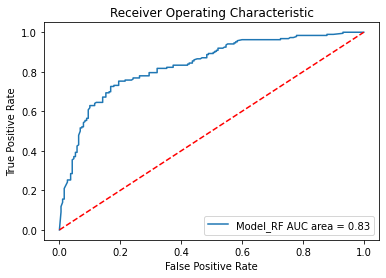

In [21]:
# Initialize the list that stores all models. First one is RF.
models = [{"label": "Model_RF", "model": model_RF}]
try:
    os.mkdir('results')
except:
    print("Directory already exists, continuing")
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y)
result_img = '{}/results/roc_auc.png'.format(os.getcwd())
result_img

#### Support vector classifier
Here we train a SVM with a radial-basis function kernel (also: squared-exponential kernel). 
For more information, see [sklearn RBF kernel](http://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RBF.html).

In [22]:
# Specify model
model_SVM = svm.SVC(kernel="rbf", C=1, gamma=0.1, probability=True)

# Fit model on single split
performance_measures = model_training_and_validation(model_SVM, "SVM", splits)

Sensitivity: 0.79
Specificity: 0.77
AUC: 0.84


'/home/jovyan/ACMDD_Tyk2_2022/Report_data/results/roc_auc.png'

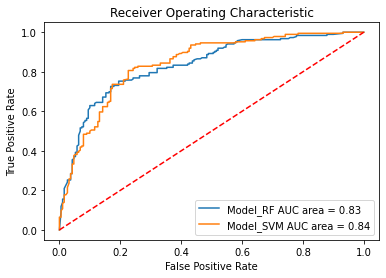

In [23]:
# Append SVM model
models.append({"label": "Model_SVM", "model": model_SVM})
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y)
result_img = '{}/results/roc_auc.png'.format(os.getcwd())
result_img

#### Neural network classifier
The last approach we try here is a neural network model. We train an MLPClassifier (Multi-layer Perceptron classifier) with 3 layers, each with 5 neurons. As before, we do the crossvalidation procedure and plot the results. For more information on MLP, see [sklearn MLPClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html).

In [24]:
# Specify model
model_ANN = MLPClassifier(hidden_layer_sizes=(5, 3), random_state=12)

# Fit model on single split
performance_measures = model_training_and_validation(model_ANN, "ANN", splits)

Sensitivity: 0.76
Specificity: 0.69
AUC: 0.81


'/home/jovyan/ACMDD_Tyk2_2022/Report_data/results/roc_auc.png'

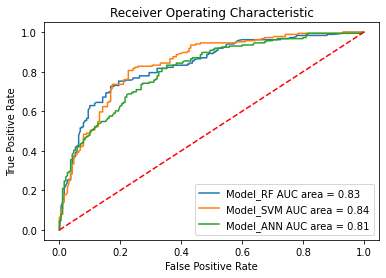

In [25]:
# Append ANN model
models.append({"label": "Model_ANN", "model": model_ANN})
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y, True)
result_img = '{}/results/roc_auc.png'.format(os.getcwd())
result_img

Our models show very good values for all measured values (see AUCs) and thus seem to be predictive.

#### Cross-validation

Next, we will perform cross-validation experiments with the three different models.
Therefore, we define a helper function for machine learning model training and validation in a cross-validation loop.

**Cross-validation**

We now apply cross-validation and show the statistics for all three ML models. In real world conditions, cross-validation usually applies 5 or more folds, but for the sake of performance we will reduce it to 3. You can change the value of `N_FOLDS` in this cell below.

In [26]:
N_FOLDS = 3

_Note_: Next cell takes long to execute

In [27]:
for model in models:
    print("\n======= ")
    print(f"{model['label']}")
    crossvalidation(model["model"], compound_df, n_folds=N_FOLDS)


Model_RF
Mean accuracy: 0.78 	and std : 0.00 
Mean sensitivity: 0.79 	and std : 0.01 
Mean specificity: 0.77 	and std : 0.01 
Mean AUC: 0.84 	and std : 0.01 
Time taken : 1.21s


Model_SVM
Mean accuracy: 0.79 	and std : 0.01 
Mean sensitivity: 0.78 	and std : 0.03 
Mean specificity: 0.79 	and std : 0.01 
Mean AUC: 0.85 	and std : 0.01 
Time taken : 4.07s


Model_ANN
Mean accuracy: 0.74 	and std : 0.00 
Mean sensitivity: 0.75 	and std : 0.02 
Mean specificity: 0.74 	and std : 0.01 
Mean AUC: 0.82 	and std : 0.01 
Time taken : 3.61s



We look at the cross-validation performance for molecules encoded using Morgan fingerprint and not MACCS keys.

In [28]:
# Reset data frame
compound_df = compound_df.drop(['fp'], axis=1)

In [29]:
# Use Morgan fingerprint with radius 3
compound_df["fp"] = compound_df["Smiles"].apply(smiles_to_fp, args=("morgan3",))
compound_df.head(3)
# NBVAL_CHECK_OUTPUT

,Molecule ChEMBL ID,pChEMBL_value,Smiles,Assay_Type,Standard Relation,Standard Value,active,fp
0,CHEMBL2181327,7.15,CN(C)CCN(C)c1ccc2cc1COCC=CCOCc1cccc(c1)-c1ccnc...,B,'=',71.0,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
1,CHEMBL2181315,5.28,C1=CCCOc2cccc(c2)-c2ccnc(n2)Nc2cccc(c2)OCC1,B,'=',5200.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
2,CHEMBL21156,9.00,CC(C)(C)c1nc2c3ccc(F)cc3c3c(=O)[nH]ccc3c2[nH]1,B,'=',1.0,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


_Note_: Next cell takes long to execute

In [30]:
for model in models:
    if model["label"] == "Model_SVM":
        # SVM is super slow with long fingerprints
        # and will have a performance similar to RF
        # We can skip it in this test, but if you want
        # to run it, feel free to replace `continue` with `pass`
        continue
    print("\n=======")
    print(model["label"])
    reduced_df = compound_df[['active','fp']]
    crossvalidation(model["model"], reduced_df, n_folds=N_FOLDS)


Model_RF
Mean accuracy: 0.78 	and std : 0.01 
Mean sensitivity: 0.79 	and std : 0.02 
Mean specificity: 0.78 	and std : 0.01 
Mean AUC: 0.86 	and std : 0.01 
Time taken : 3.47s


Model_ANN
Mean accuracy: 0.76 	and std : 0.01 
Mean sensitivity: 0.76 	and std : 0.04 
Mean specificity: 0.76 	and std : 0.03 
Mean AUC: 0.85 	and std : 0.01 
Time taken : 54.69s



So far, we have been running classification models (is the compound going to be active or not, indicated by the active column we added in the dataframe). The next step is to see if we can also train a regression model. We will remove the censored data (the ones with no pChEMBL value), and train another model. 

Make a new function that works with regression:

Next, make new data and run.

In [31]:
fingerprint_to_model = compound_df.fp.tolist()
label_to_model = compound_df.pChEMBL_value.tolist()

# Split data randomly in train and test set
# note that we use test/train_x for the respective fingerprint splits
# and test/train_y for the respective label splits
(
    static_train_x,
    static_test_x,
    static_train_y,
    static_test_y,
) = train_test_split(fingerprint_to_model, label_to_model, test_size=0.2, random_state=12)
splits = [static_train_x, static_test_x, static_train_y, static_test_y]
# NBVAL_CHECK_OUTPUT
print("Training data size:", len(static_train_x))
print("Test data size:", len(static_test_x))

Training data size: 1504
Test data size: 376


### Regressor comparison
Random forest regressor

In [32]:
# Kick out NaN in the pChEMBL values
compound_df_noNaN = compound_df.dropna()

# Append RF Regressor model
#models.append({"label": "Model_RF_reg", "model": RandomForestRegressor})
#Train model with RandomForestRegressor
regressor = RandomForestRegressor()
MAE, RMSE,trained_model = crossvalidation_reg(regressor , compound_df_noNaN, n_folds=3)

print(
f"MAE: {np.mean(MAE):.2f} \t"
f"and std : {np.std(MAE):.2f} \n"
f"RMSE: {np.mean(RMSE):.2f} \t"
f"and std : {np.std(RMSE):.2f} \n"
)

MAE: 0.55 	and std : 0.01 
RMSE: 0.77 	and std : 0.00 



Support vector regressor

In [33]:
from sklearn import svm
regressor = svm.SVR()

svrMAE, svrRMSE,svrtrained_model = crossvalidation_reg(regressor , compound_df_noNaN, n_folds=3)

print(
f"MAE: {np.mean(svrMAE):.2f} \t"
f"and std : {np.std(svrMAE):.2f} \n"
f"RMSE: {np.mean(svrRMSE):.2f} \t"
f"and std : {np.std(svrRMSE):.2f} \n"
)

MAE: 0.52 	and std : 0.01 
RMSE: 0.72 	and std : 0.01 



Multi layer perceptron regressor

In [34]:
from sklearn.neural_network import MLPRegressor
regressor = MLPRegressor()
nnMAE, nnRMSE,nntrained_model = crossvalidation_reg(regressor , compound_df_noNaN, n_folds=3)

print(
f"MAE: {np.mean(nnMAE):.2f} \t"
f"and std : {np.std(nnMAE):.2f} \n"
f"RMSE: {np.mean(nnRMSE):.2f} \t"
f"and std : {np.std(nnRMSE):.2f} \n"
)

MAE: 0.71 	and std : 0.02 
RMSE: 0.96 	and std : 0.03 



### Gathering compounds to screen with the regression model

To obtain a dataset of compounds to screen with the regression model, a few ligands were queried on pubchem. These so called query ligands were chosen to be representative for good TYK2 ligands. Among these are the reference ligand, two compounds with the highest pChEMBL values, and six compounds that are already on the market. These compounds were used to query a similarity search on pubchem with the following settings: <br>
- Similarity >= 90%
- XLogP <= 5
- Exact Mass <= 1000 <br>

In [36]:
#Dataframe of query compounds
query_df = pd.DataFrame({
    "ligand ID":["Reference_0X5",
                         "CHEMBL4789639",
                         "CHEMBL4793760",
                         "Deucravacitinib",
                         "Ruxolitinib",
                         "AT-9283",
                         "Peficitinib",
                         "Tofacitinib",
                         "Baricitinib"
                         ],
     "SMILES":['C1CC1C(=O)NC2=NC=CC(=C2)NC(=O)C3=C(C=CC=C3Cl)Cl', #0X5, PDB reference ligand
               '[2H]C([2H])([2H])NC(=O)c1cnc(NC(=O)C2CC2)cc1Nc1cccc(-c2ncc(F)cn2)c1OC', #CHEMBL4789639
               '[2H]C([2H])([2H])NC(=O)c1cnc(NC(=O)C2CC2)cc1Nc1cc(F)cc(-c2ncccn2)c1OC', #CHEMBL4793760
               '[2H]C([2H])([2H])NC(=O)c1nnc(NC(=O)C2CC2)cc1Nc1cccc(-c2ncn(C)n2)c1OC', #Deucravacitinib, TYK2
               'N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1', #Ruxolitinib, TYK2
               'O=C(Nc1c[nH]nc1-c1nc2ccc(CN3CCOCC3)cc2[nH]1)NC1CC1', #AT-9283, TYK2
               'NC(=O)c1cnc2[nH]ccc2c1N[C@H]1[C@H]2CC3C[C@@H]1C[C@](O)(C3)C2', #Peficitinib, TYK2
               'CC1CCN(CC1N(C)C2=NC=NC3=C2C=CN3)C(=O)CC#N', #Tofacitinib, JAK
               'CCS(=O)(=O)N1CC(CC#N)(n2cc(-c3ncnc4[nH]ccc34)cn2)C1' #Baricitinib, TYK2
            ]})

#Creating a list of query compound smiles
querylist = query_df['SMILES'].tolist()

#Loop to query each smiles in the query list. Results are filtered 
screening = []
for query in querylist:
    print("\n\n\nCurrently querying smiles: {}.\n".format(query))
    #Query smiles
    job_key = query_pubchem_for_similar_compounds(query, threshold=90, n_records=10000)
    similar_cids = check_and_download(job_key)
    #Gather compound properties to filter
    a= pcp.get_properties(['canonical_smiles', 'XLogP', 'ExactMass'], similar_cids)
    a= pd.DataFrame.from_records(a).dropna()
    a['ExactMass'] = a['ExactMass'].astype(float)
    a[(a['XLogP'] <= 5) & (a['ExactMass'] <= 1000)]
    a=list(a['CanonicalSMILES'])
    #Add results to screening list
    screening.extend(a)
    print("\nThis query resulted in {} results,\nwhich makes the current amount of compounds in the screening dataset {}.".format(len(a),len(screening)))

print("\nThe amount of compounds currently in the screening dataset is: {}.".format(len(screening)))

print("\nA few examples are: \n{}, \n{},\n{}.".format(screening[1],screening[2],screening[3]))




Currently querying smiles: C1CC1C(=O)NC2=NC=CC(=C2)NC(=O)C3=C(C=CC=C3Cl)Cl.



ConnectionError: HTTPSConnectionPool(host='pubchem.ncbi.nlm.nih.gov', port=443): Max retries exceeded with url: /rest/pug/compound/similarity/smiles/C1CC1C%28%3DO%29NC2%3DNC%3DCC%28%3DC2%29NC%28%3DO%29C3%3DC%28C%3DCC%3DC3Cl%29Cl/JSON?Threshold=90&MaxRecords=10000&fullsearch=true&mw_lte=1000&xlogp_lte=5 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f0d09ef9b20>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution'))

#### Adding the queried compounds to the dataset and generating the fingerprints.
The smiles results from the similarity search are transfered to a testing dataset. The queried smiles are added to the front of this dataset to include them in the regression model's predictions. Each smiles will have a morgan3 fingerprint added.

In [38]:
test_smiles = screening.copy()
test_smiles = querylist+test_smiles  #this makes sure the queried compounds are being predicted as well, some but not all of them are already in this list, but duplicates are dropped anyways.
fps = []
drop = []

for smiles in test_smiles: 
    try:
        fp = smiles_to_fp(smiles,'morgan3')
        fps.append(fp)
    except:
        drop.append(smiles)
        
for i in drop:
    test_smiles.remove(i)


#### Making bioactivity predictions on the testing dataset
The testing dataset is put through the regression model to predict their pChEMBL values. An amount of the highest ranking smiles are gathered in the screened dataframe. This amount is set with *topslice*, which in this case is set to 10.<br><br> Because it is likely that there is one of the initial queried compounds from the ChEMBL dataset among the highest ranking smiles, there is a bit of code that removes them and replaces them with the next highest ranking smiles from the predicted dataset. The queried smiles are once again added to the final dataset to be able to compare them to the highest ranking smiles when docking.

In [39]:
#set number of highest predicted compounds you'd like in the dataset    
topslice=10

screened_df = pd.DataFrame()
pd.options.display.max_colwidth = 200
screened_df["smiles"] = test_smiles
predictions = trained_model.predict(fps)

screened_df["prediction"] = predictions
screened_df["prediction_type"] = "regression"
screened_df = screened_df.drop_duplicates(subset = 'smiles')
print("Excluding duplicates, a total of {} pChEMBL values have been predicted".format(len(screened_df)))
screened_df_full = screened_df.copy()
screened_df = screened_df.sort_values(by="prediction", ascending = False)[:topslice]
file = "SCREENEDDATA.csv"
screened_df.to_csv(file)

screened_data = screened_df.copy() #Alternatively use: pd.read_csv("SCREENEDDATA.csv")
display(screened_data)

#The first few indices are the queried compound, this code checks for duplicates in the top 5 predicted compounds and replaces them with the next highest predicted smiles
#nr of top predicted values to replace duplicate with
appendindex = topslice+1
while sum(screened_data.index<=(len(querylist)-1))>0:
    Index = screened_data.index[screened_data.index<(len(querylist)-1)][0] #index of the duplicate
    print(f"One of the top {len(screened_data)} predicted values ({query_df.iloc[Index][1]}) is one of the queried compounds: {query_df.iloc[Index][0]}, replacing it with the nr {appendindex} of the regression predicted smiles")
    screened_data = screened_data.drop(Index)
    screened_data = screened_data.append(screened_df_full.sort_values(by="prediction", ascending = False)[appendindex-1:appendindex]) #drop duplicate and append next highest predicted element
    appendindex += 1

#Creates list of ligand id's for the predicted values based, supports any number of predicted values
predicted_nr = []
for i in range(sum(screened_data.index>(len(querylist)-1))):
    predicted_nr.append("Predicted_nr"+str(i+1))

#adds queried ligands to dataframe
screened_data = screened_df_full[screened_df_full['smiles'].isin(querylist)].append(screened_data).drop_duplicates(subset = 'smiles')
identifiers = pd.DataFrame({"ligand ID": query_df['ligand ID'].append(pd.Series(predicted_nr)).reset_index(drop=True)})
screened_data["ligand ID"] = identifiers.values #names ligands
display(screened_data)
docking_smiles = screened_data['smiles']
print(docking_smiles)

Excluding duplicates, a total of 9 pChEMBL values have been predicted


,smiles,prediction,prediction_type
3,[2H]C([2H])([2H])NC(=O)c1nnc(NC(=O)C2CC2)cc1Nc1cccc(-c2ncn(C)n2)c1OC,8.759103,regression
5,O=C(Nc1c[nH]nc1-c1nc2ccc(CN3CCOCC3)cc2[nH]1)NC1CC1,8.300647,regression
2,[2H]C([2H])([2H])NC(=O)c1cnc(NC(=O)C2CC2)cc1Nc1cc(F)cc(-c2ncccn2)c1OC,8.290312,regression
6,NC(=O)c1cnc2[nH]ccc2c1N[C@H]1[C@H]2CC3C[C@@H]1C[C@](O)(C3)C2,8.283975,regression
1,[2H]C([2H])([2H])NC(=O)c1cnc(NC(=O)C2CC2)cc1Nc1cccc(-c2ncc(F)cn2)c1OC,7.994528,regression
4,N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1,7.929213,regression
8,CCS(=O)(=O)N1CC(CC#N)(n2cc(-c3ncnc4[nH]ccc34)cn2)C1,7.401514,regression
7,CC1CCN(CC1N(C)C2=NC=NC3=C2C=CN3)C(=O)CC#N,7.252759,regression
0,C1CC1C(=O)NC2=NC=CC(=C2)NC(=O)C3=C(C=CC=C3Cl)Cl,6.864581,regression


One of the top 9 predicted values ([2H]C([2H])([2H])NC(=O)c1nnc(NC(=O)C2CC2)cc1Nc1cccc(-c2ncn(C)n2)c1OC) is one of the queried compounds: Deucravacitinib, replacing it with the nr 11 of the regression predicted smiles
One of the top 8 predicted values (O=C(Nc1c[nH]nc1-c1nc2ccc(CN3CCOCC3)cc2[nH]1)NC1CC1) is one of the queried compounds: AT-9283, replacing it with the nr 12 of the regression predicted smiles
One of the top 7 predicted values ([2H]C([2H])([2H])NC(=O)c1cnc(NC(=O)C2CC2)cc1Nc1cc(F)cc(-c2ncccn2)c1OC) is one of the queried compounds: CHEMBL4793760, replacing it with the nr 13 of the regression predicted smiles
One of the top 6 predicted values (NC(=O)c1cnc2[nH]ccc2c1N[C@H]1[C@H]2CC3C[C@@H]1C[C@](O)(C3)C2) is one of the queried compounds: Peficitinib, replacing it with the nr 14 of the regression predicted smiles
One of the top 5 predicted values ([2H]C([2H])([2H])NC(=O)c1cnc(NC(=O)C2CC2)cc1Nc1cccc(-c2ncc(F)cn2)c1OC) is one of the queried compounds: CHEMBL4789639, replacing it 

IndexError: index 0 is out of bounds for axis 0 with size 0

## Discussion

* Which model performed best on our data set and why?
    * All three models perform (very) well on our dataset. The best models are the random forest and support vector machine models which showed a mean AUC of about 90%. Our neural network showed slightly lower results. 
    * There might be several reasons that random forest and support vector machine models performed best. Our dataset might be easily separable in active/inactive with some simple tree-like decisions or with the radial basis function, respectively. Thus, there is not such a complex pattern in the fingerprints to do this classification.
    * A cause for the slightly poorer performance of the ANN could be that there was simply too few data to train the model on.
    * Additionally, it is always advisable to have another external validation set for model evaluation.  
* Was MACCS the right choice?
    * Obviously, MACCS was good to start training and validating models to see if a classification is possible. 
    * However, MACCS keys are rather short (166 bit) compared to others (2048 bit), as for example Morgan fingerprint. As shown in the last simulation, having longer fingerprint helps the learning process. All tested models performed slightly better using Morgan fingerprints (see mean AUC increase).


# Molecular docking


The 3D coordinates are generated for each of the smiles in the docking dataframe.

In [40]:
i = -1

IDs = []
for i in range(0,len(docking_smiles)):
    base = identifiers["ligand ID"][i]
    IDs.append(base)
    
df = pd.DataFrame({'ID':IDs, 'SMILES':docking_smiles})

df['rdkit_mol'] = [Chem.MolFromSmiles(s) for s in df['SMILES']]

# Generate 2D images of the molecules
img=Draw.MolsToGridImage(df['rdkit_mol'].tolist(),
                            molsPerRow=6,
                            subImgSize=(250,250),
                            legends=df['ID'].tolist())

for i in range(len(df)):
    row = df.iloc[i]
    mol = row['rdkit_mol']
    name = row['ID'] + '.mol'
    Chem.MolToMolFile(mol,name)

print("The first {} ligands are from the querylist. The last {} are the top {} predicted ligands in descending order.".format(len(querylist),sum(screened_data.index>(len(querylist)-1)),sum(screened_data.index>(len(querylist)-1))))
img


NameError: name 'docking_smiles' is not defined

From the images it can be seen that all of the compound with the highest predictions have a similar structure to peficitinib.

#### Docking preparation

In [ ]:
# Calculate the center based on the reference ligand
RadiusOfGyration = Rg('ligand-{}.pdb'.format(LIGAND_CODE))
print("Radius of Gyration = {}".format(RadiusOfGyration))

# Calculate center of geometry
CenterOfGeometry = COG('ligand-{}.pdb'.format(LIGAND_CODE))
print("Center Of Geometry = {}".format(CenterOfGeometry))

In [ ]:
protein = Chem.MolFromPDBFile('{}_prepped.pdb'.format(TARGET_PDB_ID))
a = MolToPDBQTBlock(protein,flexible=False)
with open('protein.pdbqt','w') as outfile:
    for line in a:
        outfile.write(line)

In [ ]:
docking_smiles

#### Docking the smiles to the protein

In this step the queried compounds and top regression compounds are docked to the protein. The settings for this docking are:
- Seed = 1
- Exhaustiveness = 20
- N_poses = 40.<br><br>
This step takes a while so it is also possible to load the pre-docked csv file.

In [ ]:
#Load saved data?
Load_data = True

if Load_data == True:
    print("Loading previous dataset")
    complete_data = pd.read_csv("complete_data_10_compounds_40_20.csv")
else:
    df_cols = {'ligand ID':[], 'vina_affinity': [],"prediction": [], 'prediction_type': [], 'exhaustiveness': [], 'n_poses': []}
    docked_ligands = pd.DataFrame(data=df_cols)

    for ID in df['ID']:
        print(f"\nDocking ligand ID: {ID}\n")
        for i in range(1,2,1):
            LIGAND_TO_DOCK = ID 
            m = Chem.MolFromMolFile('{}.mol'.format(LIGAND_TO_DOCK))
            a = MolToPDBQTBlock(m)
            with open('{}.pdbqt'.format(LIGAND_TO_DOCK), 'w') as outfile:
                for line in a:
                    outfile.write(line)

            v = Vina(sf_name='vina', seed = SEED)

            v.set_receptor('protein.pdbqt')

            v.set_ligand_from_file('{}.pdbqt'.format(LIGAND_TO_DOCK))

            center = {
                 'center_x' : CenterOfGeometry[0], 
                 'center_y' : CenterOfGeometry[1], 
                 'center_z' : CenterOfGeometry[2]

            }

            size = { 
                'size_x' : RadiusOfGyration * 2.9 ,
                'size_y' : RadiusOfGyration * 2.9,
                'size_z' : RadiusOfGyration * 2.9,           
                       }


            v.compute_vina_maps(center=[center['center_x'], center['center_y'], center['center_z']], 
                                box_size=[size['size_x'], size['size_y'], size['size_z']])

            '''
            # Score the current pose
            energy = v.score()
            print('Score before minimization: %.3f (kcal/mol)' % energy[0])

            # Minimized locally the current pose
            energy_minimized = v.optimize()
            print('Score after minimization : %.3f (kcal/mol)' % energy_minimized[0])
            v.write_pose('1iep_ligand_minimized.pdbqt', overwrite=True)
            '''

            # Dock the ligand
            v.dock(exhaustiveness=20, n_poses=40)
            v.write_poses('docking_results.pdbqt', n_poses=1, overwrite=True)

            # Create a mol object from the docking results, write the mol to file and print the predicted affinity
            mol = MolFromPDBQTBlock('docking_results.pdbqt',sanitize=False)
            Chem.rdmolfiles.MolToPDBFile(mol, '{}_docked.pdb'.format(LIGAND_TO_DOCK))
            Ki = (math.exp(float(mol.GetProp('vina_affinity'))/0.592))
            pKi = -math.log10(Ki)
            pChEMBL = pKi
            print('The affinity predicted by Vina = {} (kcal/mol)'.format(mol.GetProp('vina_affinity')))
            print('Which (approximately) corresponds to a pChEMBL of {:.2f}'.format(pKi))
            docked_ligands.loc[len(docked_ligands)] = [LIGAND_TO_DOCK, mol.GetProp('vina_affinity'), pChEMBL, "docking", 20, 40]


    print(docked_ligands)


    docked_ligands['smiles'] = docking_smiles.to_list()
    complete_data = screened_data.append(docked_ligands).reset_index(drop=True)
    #warning this code depends on querylist, i do not know a dynamic way to code this (well i havent looked it up yet)
    chembldata=compound_df_noNaN.query('Smiles in @querylist')
    chembldata['prediction_type'] = "actual"
    chembldata['prediction'] = chembldata["pChEMBL_value"]
    chembldata['smiles'] = chembldata["Smiles"]
    chembldata = chembldata.drop(['fp', "Assay_Type", "Standard Relation", "Standard Value", "active", "Smiles", "pChEMBL_value"], axis =1)
    complete_data = complete_data.append(chembldata)
    complete_data['ligand ID'] = complete_data['smiles'].map(docked_ligands.set_index('smiles').to_dict()['ligand ID'])
    complete_data['Molecule ChEMBL ID'] = complete_data['smiles'].map(chembldata.set_index('smiles').to_dict()['Molecule ChEMBL ID'])

display(complete_data)


The dataframe is saved with a timestamp because the code takes a while as it usually runs in the background. This makes sure that the results are saved after docking and to preserve the data for each attempt.

In [ ]:
complete_data.to_csv("complete_data"+time.asctime( time.localtime(time.time()))+".csv")

### Docking results

In [ ]:
#Create subplot
fig = plt.figure(constrained_layout=True)
axes = fig.subplot_mosaic([['Top', 'Top'],['BottomLeft', 'BottomRight']],
                          gridspec_kw={'width_ratios':[1, 1]},)
fig.set_size_inches(16, 10)

sns.set_theme(style="ticks", rc={"axes.spines.right": False, "axes.spines.top": False})

#Plot to compare regression predictions
plt.sca(axes['BottomLeft'])
sns.barplot(
    data=complete_data[complete_data['prediction_type']=="regression"],
    x="ligand ID", y="prediction", palette="GnBu_d"
)

plt.xticks(rotation=60, ha='right')
axes['BottomLeft'].set(title = "Regression predictions",
       xlabel = " ",
       ylabel = "predicted pIC50 value")
axes['BottomLeft'].axhline(
    complete_data.query('`ligand ID` == "Reference_0X5" and prediction_type == "regression"')['prediction'].values[0],
    ls='--', c='red')


#Plot to compare docking predictions
plt.sca(axes['BottomRight'])
sns.barplot(
    data=complete_data[complete_data['prediction_type']=="docking"],
    x="ligand ID", y="prediction", palette="GnBu_d"
)

plt.xticks(rotation=60, ha='right')
axes['BottomRight'].set(title = "Docking predictions",
       xlabel = " ",
       ylabel = "predicted pIC50 value")
axes['BottomRight'].axhline(
    complete_data.query('`ligand ID` == "Reference_0X5" and prediction_type == "docking"')['prediction'].values[0],
    ls='--', c='red')

#Top plot to compare prediction types
plt.sca(axes['Top'])
sns.barplot(
    data=complete_data.query('smiles in @querylist'),
    x="ligand ID", y="prediction", hue="prediction_type", palette="GnBu_d"
)
plt.xticks(rotation=60, ha='right')
axes['Top'].set(title = "Comparison",
       ylabel = "pIC50 value")
axes['Top'].legend(title='pIC50 type',loc=2, bbox_to_anchor=(1,1))

#saves the plots
plt.savefig("plots.png", dpi=400);

From this plot it can be seen that the regression predictions are usually close to the actual values. This is expected because the model is trained on this. The docking predictions are not as close to the actual values as the regression predictions and tend to be lower.<br><br>
All of the compounds have a higher predicted pChEMBL value compared to the reference ligand 0X5. On the other hand, not all compounds have a higher value when predicted with the docking score. However, all of the predicted compound were higher, with Predicted_nr3 having a value above 10.

In [49]:
#for an overview of the ligand id's
df['ID'].values

NameError: name 'df' is not defined

#### Comparison of the reference ligand and the highest scoring docked compound

In [ ]:
LIGAND_TO_SHOW = 'Predicted_nr3'
print(f"Showing {LIGAND_TO_SHOW}")
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('{}_prepped.pdb'.format(TARGET_PDB_ID),'r').read(),format='pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})

ligtmp = 'ligand-{}.pdb'.format(LIGAND_CODE)
view.addModels(open(ligtmp,'r').read(),format='pdb')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'magentaCarbon','radius':0.2}})

docktmp = 'Predicted_nr3_docked.pdb'
view.addModels(open(docktmp,'r').read(),format='pdb')
x = view.getModel()
x.setStyle({},{'stick':{'colorscheme':'cyanCarbon','radius':0.2}})

print('Reference: Magenta | Vina Pose: Cyan')

view.zoomTo()
view.show()

The nr 3 predicted compound fits well inside of the binding pocket. It mostly occupies the same space as the reference ligand.

#### The highest scoring compound alongside its parental (by similiarity) compound

In [ ]:
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('{}_prepped.pdb'.format(TARGET_PDB_ID),'r').read(),format='pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})

ligtmp = 'Peficitinib_docked.pdb'
view.addModels(open(ligtmp,'r').read(),format='pdb')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'magentaCarbon','radius':0.2}})

docktmp = 'Predicted_nr3_docked.pdb'
view.addModels(open(docktmp,'r').read(),format='pdb')
x = view.getModel()
x.setStyle({},{'stick':{'colorscheme':'cyanCarbon','radius':0.2}})

print('Reference: Magenta | Vina Pose: Cyan')

view.zoomTo()
view.show()

The nr 3 predicted compound and peficitinib have a lot in common regarding their molecular structure. It is therefore no surprise to see that they have been docked in a very similar way.

#### Showing the docked compound alongside the binding site's residues

In [1]:
# combine protein and ligand files
filenames = [
'{}_prepped.pdb'.format(TARGET_PDB_ID),
'{}_docked.pdb'.format(LIGAND_TO_SHOW)
]
with open('{}-complex.pdb'.format(TARGET_PDB_ID), 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                if not "END" in line:
                    outfile.write(line)

NameError: name 'TARGET_PDB_ID' is not defined

In [ ]:
with open('{}-complex.pdb'.format(TARGET_PDB_ID)) as f:
    view_screened = nglview.show_file(f, ext="pdb")
    
view.center("UNL")
viewer.show_residues_around(view_screened, selection="UNL")
view_screened